## Modules

In [1]:
# import basic modules
import datetime as dt
import pandas as pd
import os
import warnings
import numpy as np
import glob

In [2]:
# import all modules related to visualization
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.pyplot import plot
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [3]:
# import all modules related to statistical computing
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

In [4]:
# filter warnings
warnings.filterwarnings("ignore")

## Import Data

**Dependent Variable (seasonally adjusted):**
- Real Gross Domestic Product (GDP)

**Predictors (seasonally adjusted):**
- Real Exports (EXP)
- Industrial Production Index (IPI)
- Real Imports (IMP)
- Unemployment Rate (UNR)

In [5]:
# read in all the csv-files
# all data downloaded from the Federal-Reserve-Economic-Data (FRED) website
path = os.getcwd() + "/Raw Data"
files = glob.glob(os.path.join(path, "*.csv"))
file_list = list()
for f in files:
    df = pd.read_csv(f)
    file_list.append(df)

In [6]:
# set the date as index and select range of dates
for i in range(len(file_list)):
    file_list[i]["DATE"] = pd.to_datetime(file_list[i]["DATE"])
    file_list[i].set_index("DATE", inplace = True)
    file_list[i] = file_list[i]["1949-10-01":"2020-10-01"]

In [7]:
df = pd.concat(file_list, axis = 1).dropna()
df.columns = ["EXP", "GDP", "IPI", "IMP", "UNR"]
print(df)

                 EXP        GDP       IPI       IMP   UNR
DATE                                                     
1949-10-01    61.127   2102.251   13.8926    64.853   7.9
1950-01-01    60.119   2184.872   14.6218    66.665   6.5
1950-04-01    60.846   2251.507   15.8495    70.345   5.8
1950-07-01    62.424   2338.514   17.1234    86.806   5.0
1950-10-01    67.483   2383.291   17.4188    86.969   4.2
...              ...        ...       ...       ...   ...
2019-10-01  2557.846  19253.959  109.5728  3419.332   3.6
2020-01-01  2495.099  19010.848  107.6677  3283.110   3.5
2020-04-01  1927.417  17302.511   93.7096  2702.467  14.8
2020-07-01  2166.521  18596.521  102.5333  3185.541  10.2
2020-10-01  2278.520  18794.426  104.8758  3400.486   6.9

[285 rows x 5 columns]


## Data Overview

In [8]:
# function for visualization of the data
def graph_plot(data, name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5))
    
    # plot the original series
    ax1.plot(data, color = "darkblue", label = name)
    # estimated trend using a hodrick-prescott filter
    ax1.plot(hpfilter(data, 1600)[1], color = "green", linewidth = 1, label = r"Hodrick-Prescott Filter ($\lambda = 1600$)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel(name)
    ax1.set_title(name, loc = "left")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    ax1.legend(frameon = False)
    
    # plot the growth rates of the series
    ax2.plot(data.pct_change(), color = "darkblue")
    ax2.set_xlabel("Date")
    ax2.set_title(name + " (percent change)", loc = "left")
    ax2.axhline(y = 0, color = "red", linestyle = "--")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # layout optimization
    plt.tight_layout()

$$ \text{Hodrick-Prescott-Filter :} \;\; \min_{\tau} \left( \sum^T_{t=1}(X_{t}-\tau_{t})^2 + \lambda \sum^{T-1}_{t=2}[(\tau_{t+1}-\tau_{t})-(\tau_{t}-\tau_{t-1})]^2 \right) $$

### Real Gross Domestic Product

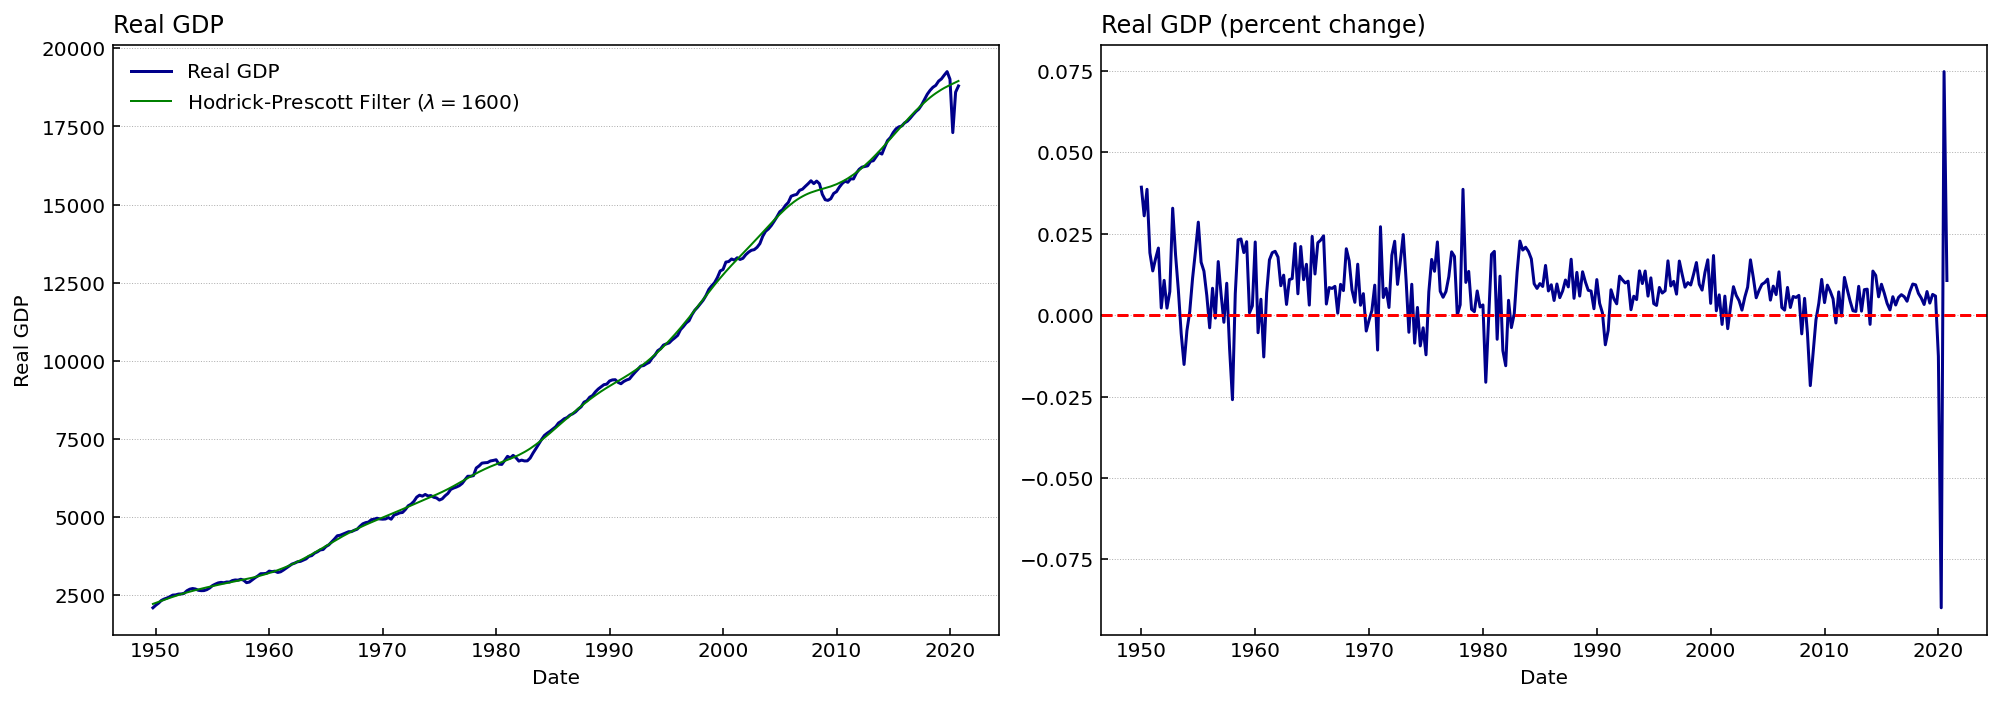

In [9]:
graph_plot(df["GDP"], "Real GDP")

### Real Exports

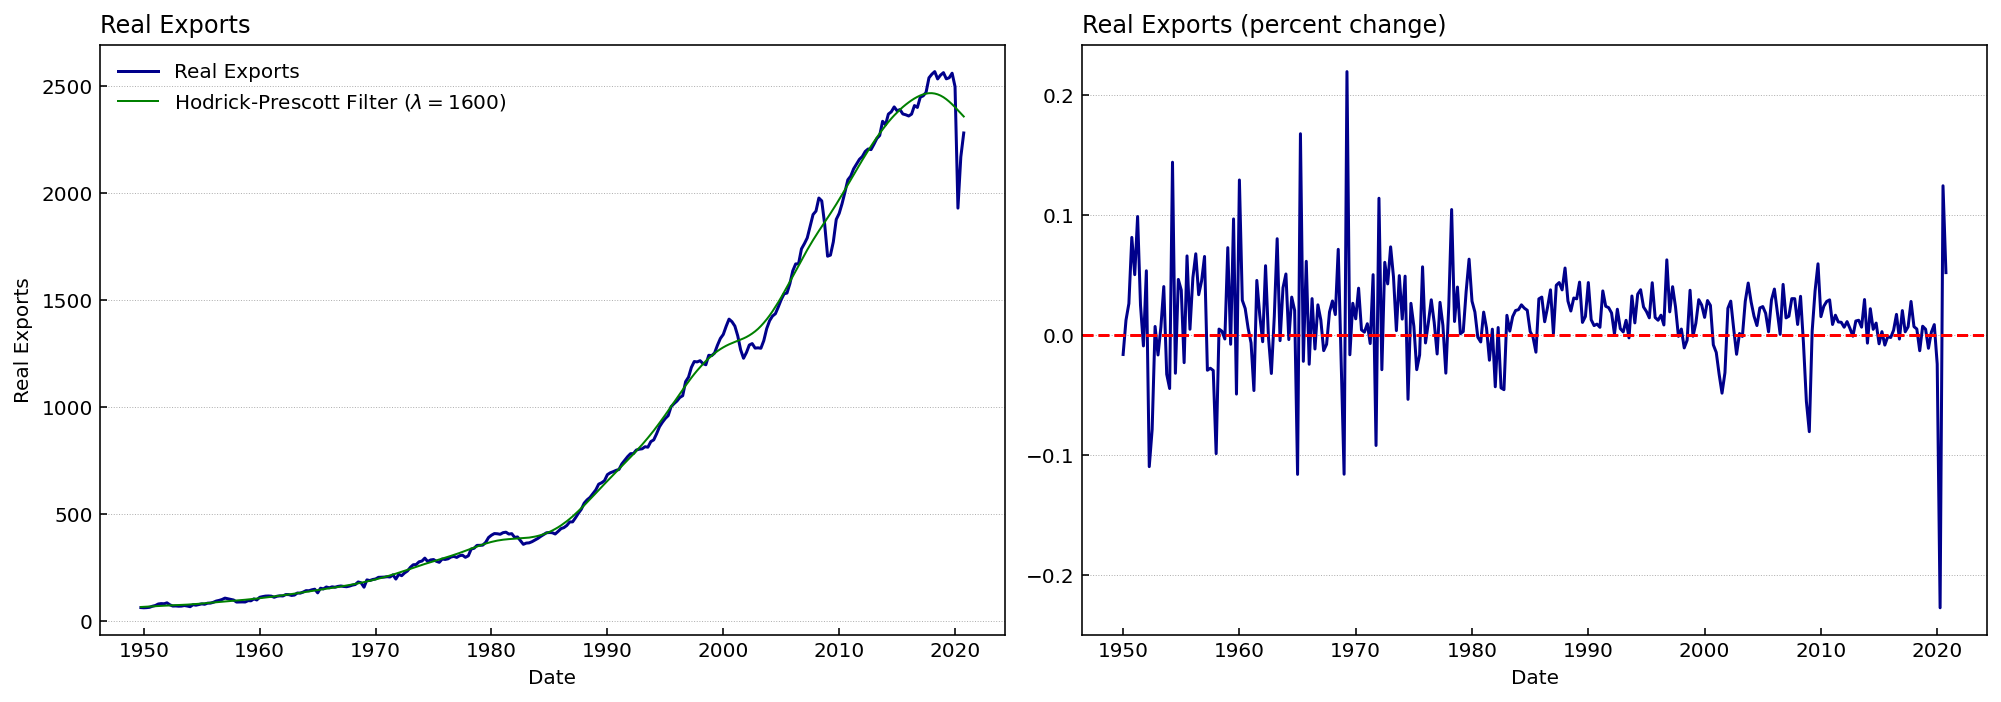

In [10]:
graph_plot(df["EXP"], "Real Exports")

### Production Index

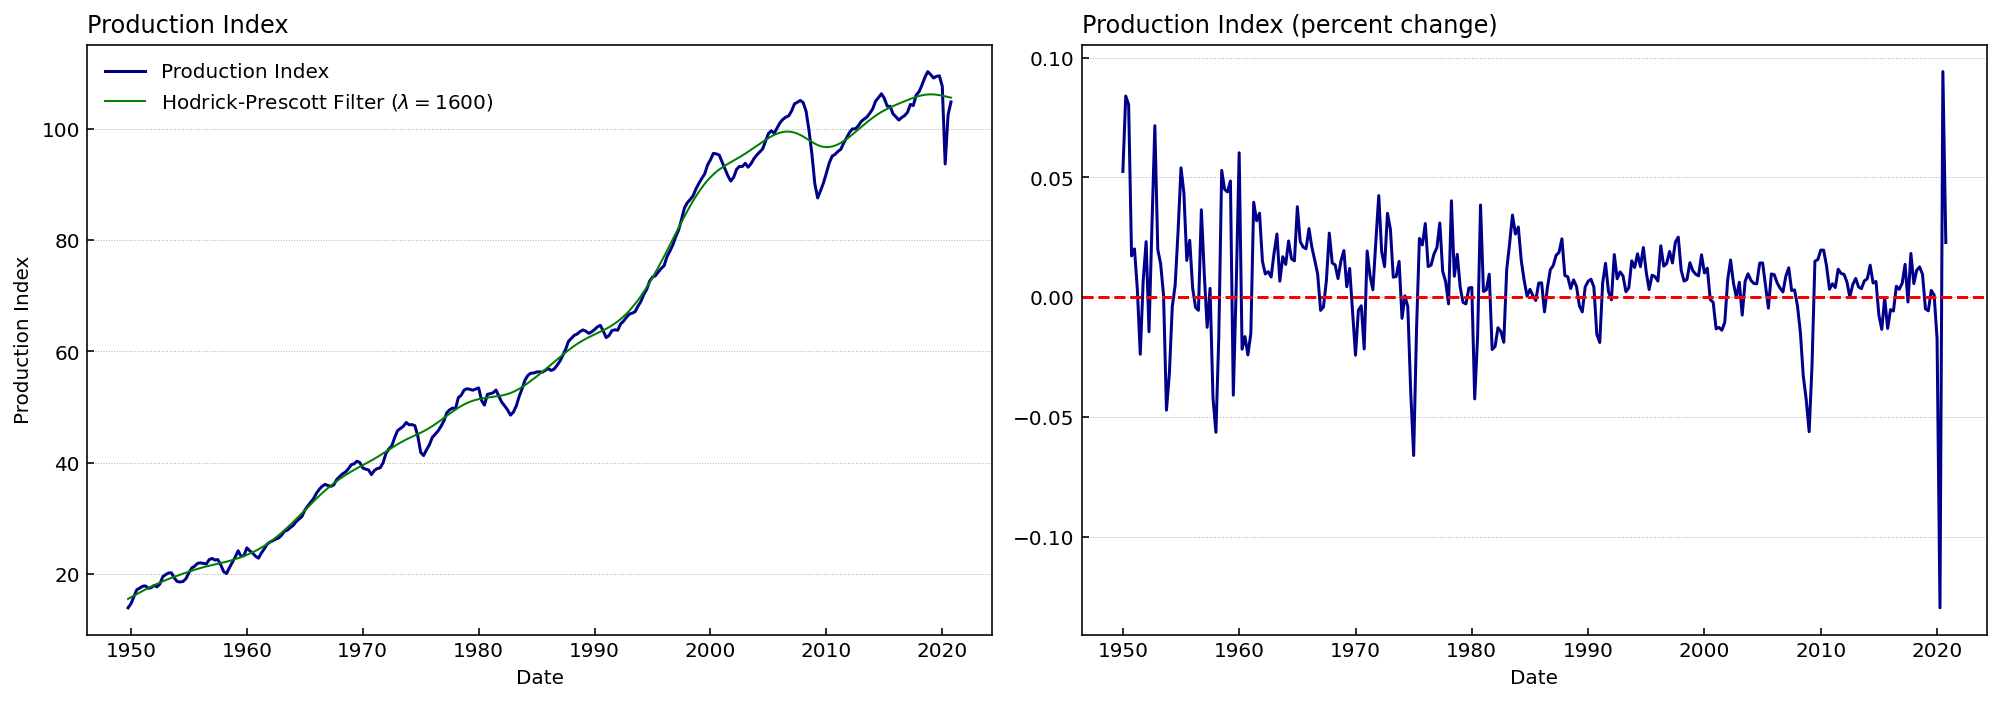

In [11]:
graph_plot(df["IPI"], "Production Index")

### Real Imports

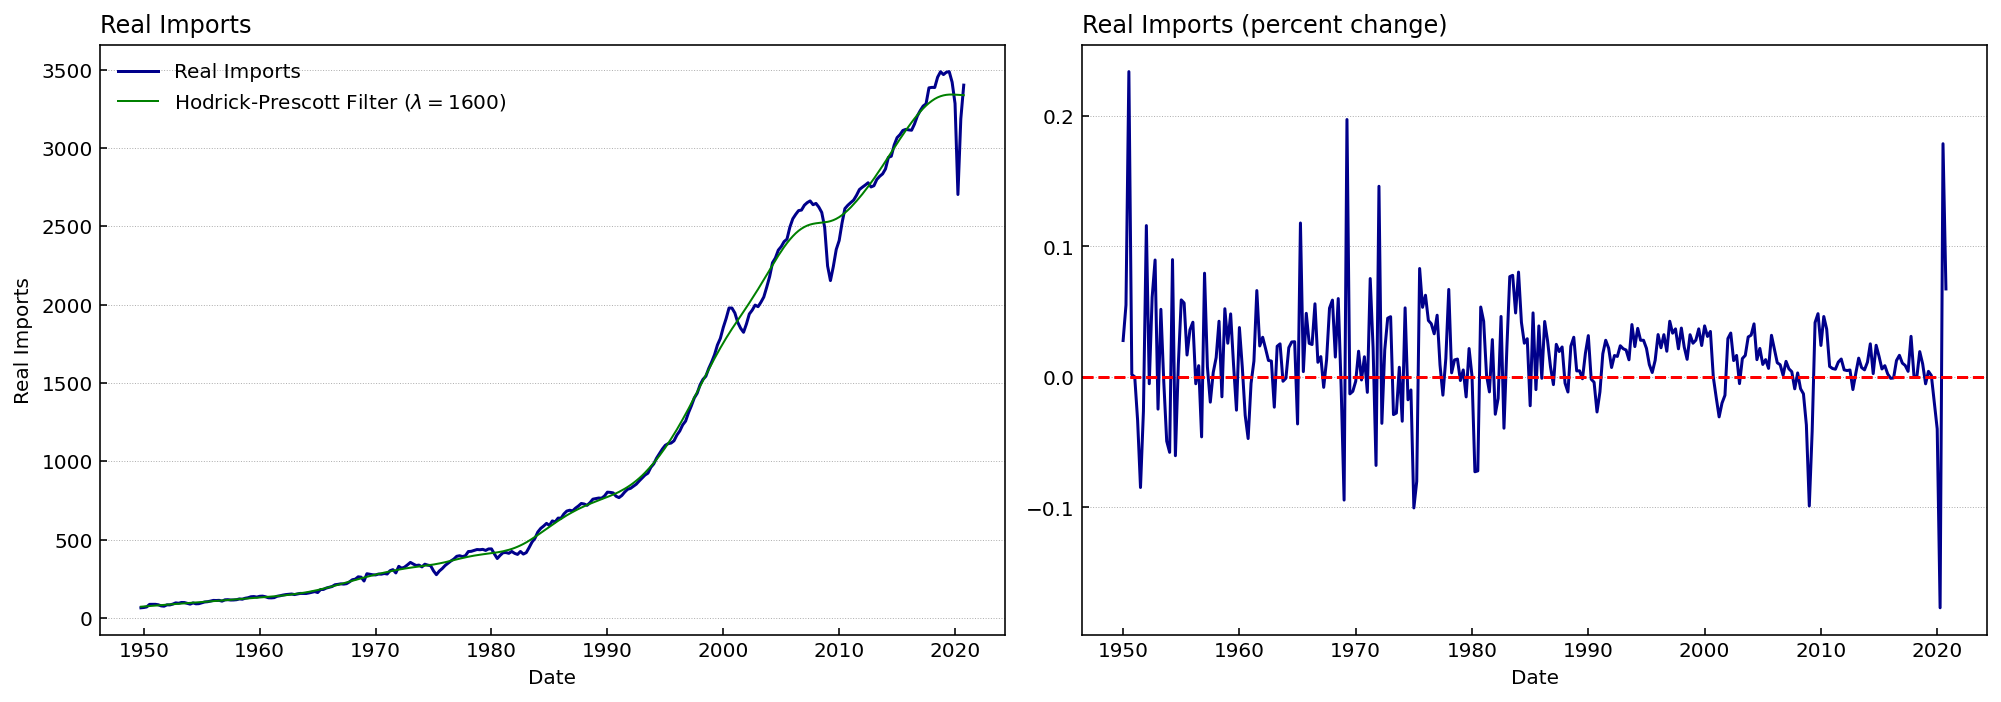

In [12]:
graph_plot(df["IMP"], "Real Imports")

### Unemployment Rate

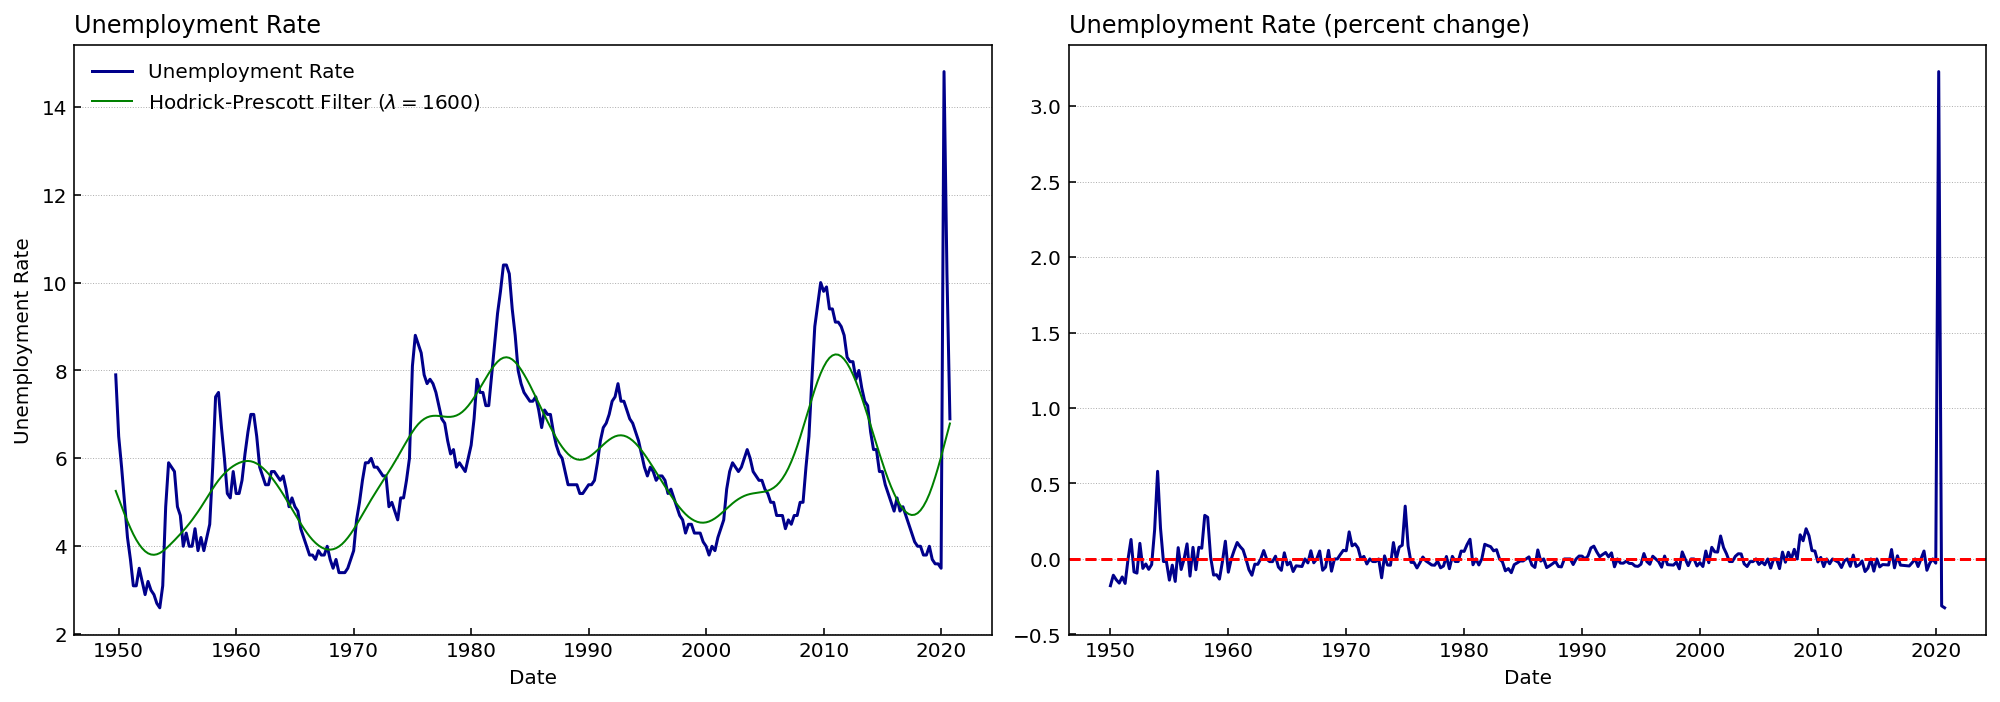

In [13]:
graph_plot(df["UNR"], "Unemployment Rate")

In [14]:
# continue analysis with growth rates
for column in df:
    if column != "UNR":
        df[column] = df[column].pct_change() * 100
    else:
        df[column] = df[column].pct_change() * 10
df.dropna(inplace = True)
df = df.round(2)
print(df)

              EXP   GDP    IPI    IMP    UNR
DATE                                        
1950-01-01  -1.65  3.93   5.25   2.79  -1.77
1950-04-01   1.21  3.05   8.40   5.52  -1.08
1950-07-01   2.59  3.86   8.04  23.40  -1.38
1950-10-01   8.10  1.91   1.73   0.19  -1.60
1951-01-01   5.00  1.36   2.01   0.01  -1.19
...           ...   ...    ...    ...    ...
2019-10-01   0.84  0.59   0.09  -1.93   0.00
2020-01-01  -2.45 -1.26  -1.74  -3.98  -0.28
2020-04-01 -22.75 -8.99 -12.96 -17.69  32.29
2020-07-01  12.41  7.48   9.42  17.88  -3.11
2020-10-01   5.17  1.06   2.28   6.75  -3.24

[284 rows x 5 columns]


$$ \text{Percent-Change :} \;\;  X_{t} = \frac{X_{t}-X_{t-1}}{X_{t-1}} \cdot 100 $$

## Stationarity

In [15]:
# ADF test
# null hypothesis : series not stationary (unit root)
# alternate hypothesis : series is stationary
# reject null hypothesis if p-value <= 0.05
def adf_test(data):
    d = 0
    # run ADF test with 1% significance level
    adf_test = adfuller(data.dropna())
    test_statistic,  p_value, crit_value = adf_test[0], adf_test[1], adf_test[4]["1%"]
    while test_statistic > crit_value:
        data = data.diff()
        adf_test = adfuller(data.dropna())
        test_statistic,  p_value, crit_value = adf_test[0], adf_test[1], adf_test[4]["1%"]
        # set order of differencing required for stationarity
        d = d + 1
    # return test results
    return test_statistic, p_value, crit_value, d

$$ \text{First-Difference :} \;\;  \Delta X_{t} = X_{t} - X_{t-1} $$

In [16]:
# run the hypothesis test on the data
adf_results = pd.DataFrame(columns = ["t-value", "p-value", "c-value", "d"], 
                       index = ["EXP", "GDP", "IPI", "IMP", "UNR"])
for column in df:
    adf_results.loc[column] = adf_test(df[column])

In [17]:
# print results
adf_results = adf_results.astype(float).round(2)
print(adf_results)

     t-value  p-value  c-value    d
EXP   -19.57      0.0    -3.45  0.0
GDP    -9.79      0.0    -3.45  0.0
IPI    -9.34      0.0    -3.45  0.0
IMP    -5.07      0.0    -3.45  0.0
UNR   -17.11      0.0    -3.45  0.0


In [18]:
# difference the data for each indicator if necessary
for i, value in enumerate(adf_results["d"]):
    j = 0
    while j != value:
        df[adf_results.index[i]] = df[adf_results.index[i]].diff()
        j = j + 1
df.dropna(inplace = True)
print(df)

              EXP   GDP    IPI    IMP    UNR
DATE                                        
1950-01-01  -1.65  3.93   5.25   2.79  -1.77
1950-04-01   1.21  3.05   8.40   5.52  -1.08
1950-07-01   2.59  3.86   8.04  23.40  -1.38
1950-10-01   8.10  1.91   1.73   0.19  -1.60
1951-01-01   5.00  1.36   2.01   0.01  -1.19
...           ...   ...    ...    ...    ...
2019-10-01   0.84  0.59   0.09  -1.93   0.00
2020-01-01  -2.45 -1.26  -1.74  -3.98  -0.28
2020-04-01 -22.75 -8.99 -12.96 -17.69  32.29
2020-07-01  12.41  7.48   9.42  17.88  -3.11
2020-10-01   5.17  1.06   2.28   6.75  -3.24

[284 rows x 5 columns]


## Autocorrelation

In [19]:
# function for visualization of the autocorrelation
def acf_plot(data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5))
        
    # compute acf values and plot them
    plot_acf(data, ax = ax1, title = "", zero = False, color = "darkblue", 
             alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax1.axhline(y = 2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax1.axhline(y = -2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax1.set_title("Autocorrelation Function", loc = "left")
    ax1.set_xlabel("Lags")
    ax1.set_ylabel("Autocorrelation")
    ax1.tick_params(direction = "in")
    ax1.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # compute pacf values and plot them
    plot_pacf(data, ax = ax2, title = "", zero = False, color = "darkblue", 
              alpha = None, lags = 50, use_vlines = True, vlines_kwargs = {"colors": "darkblue"})
    ax2.axhline(y = 2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax2.axhline(y = -2 / np.sqrt(len(data)), color = "red", linestyle = "--")
    ax2.set_title("Partial Autocorrelation Function", loc = "left")
    ax2.set_xlabel("Lags")
    ax2.set_ylabel("Partial Autocorrelation")
    ax2.tick_params(direction = "in")
    ax2.grid(axis = "y", linewidth = 0.5, linestyle = ":")
    
    # layout optimization
    plt.tight_layout()

$$ \text{Sample Autocorrelation :} \;\;  \hat{\varrho}_{h} = \frac{\sum^{T}_{t=h+1}(X_{t}-\bar{X})(X_{t-h}-\bar{X})}{\sum^{T}_{t=1}(X_{t}-\bar{X})^2} $$

### Real Gross Domestic Product

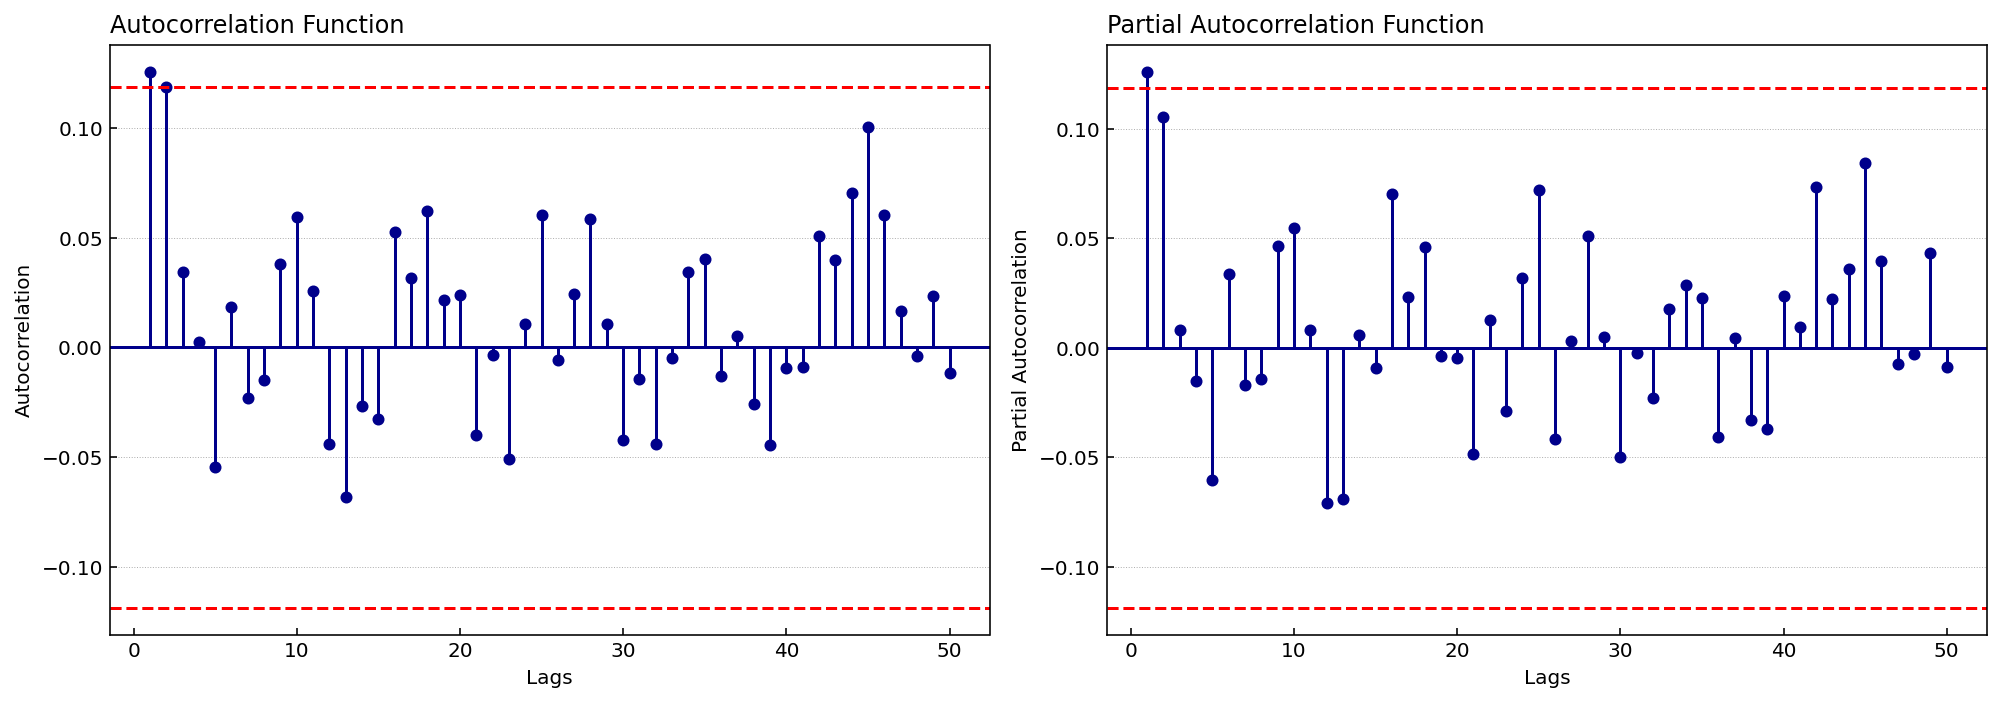

In [20]:
acf_plot(df["GDP"])

### Real Exports

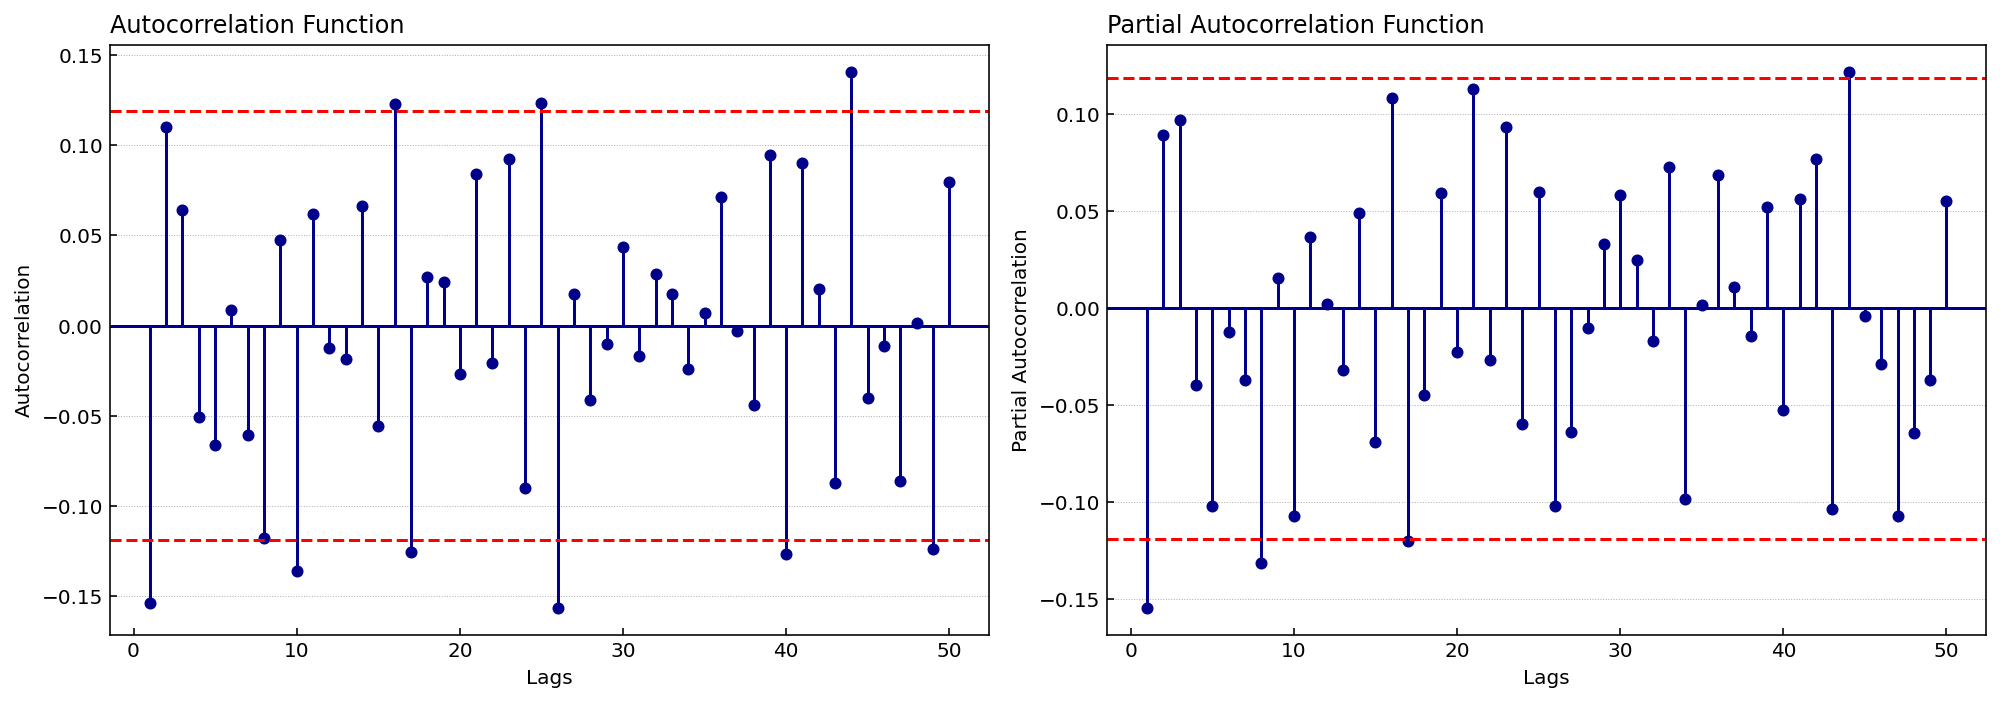

In [21]:
acf_plot(df["EXP"])

### Production Index

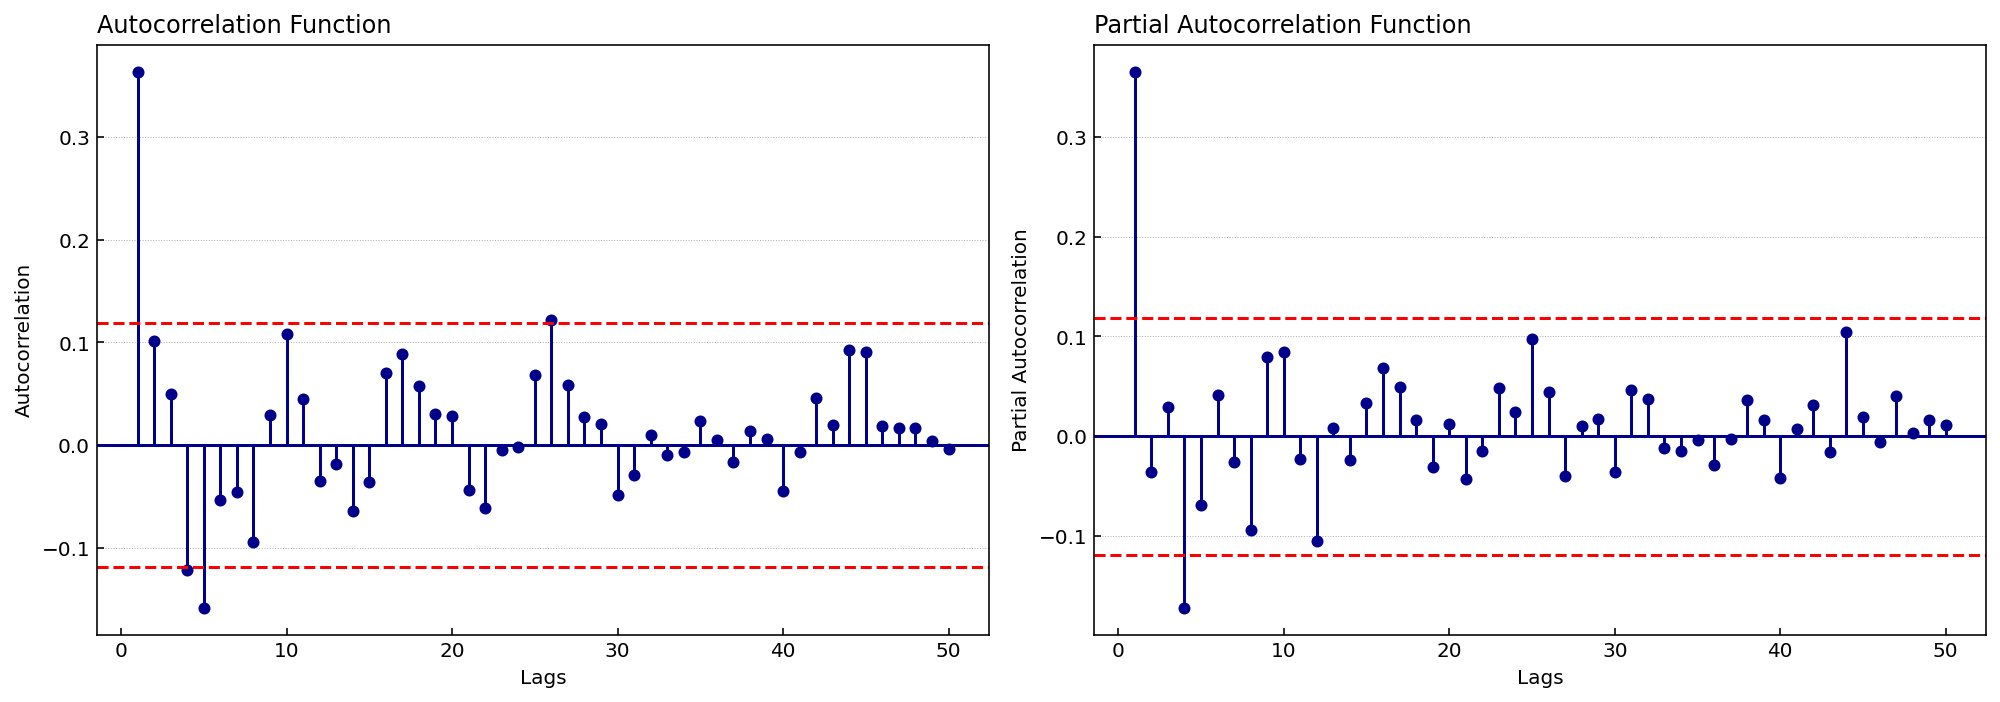

In [22]:
acf_plot(df["IPI"])

### Real Imports

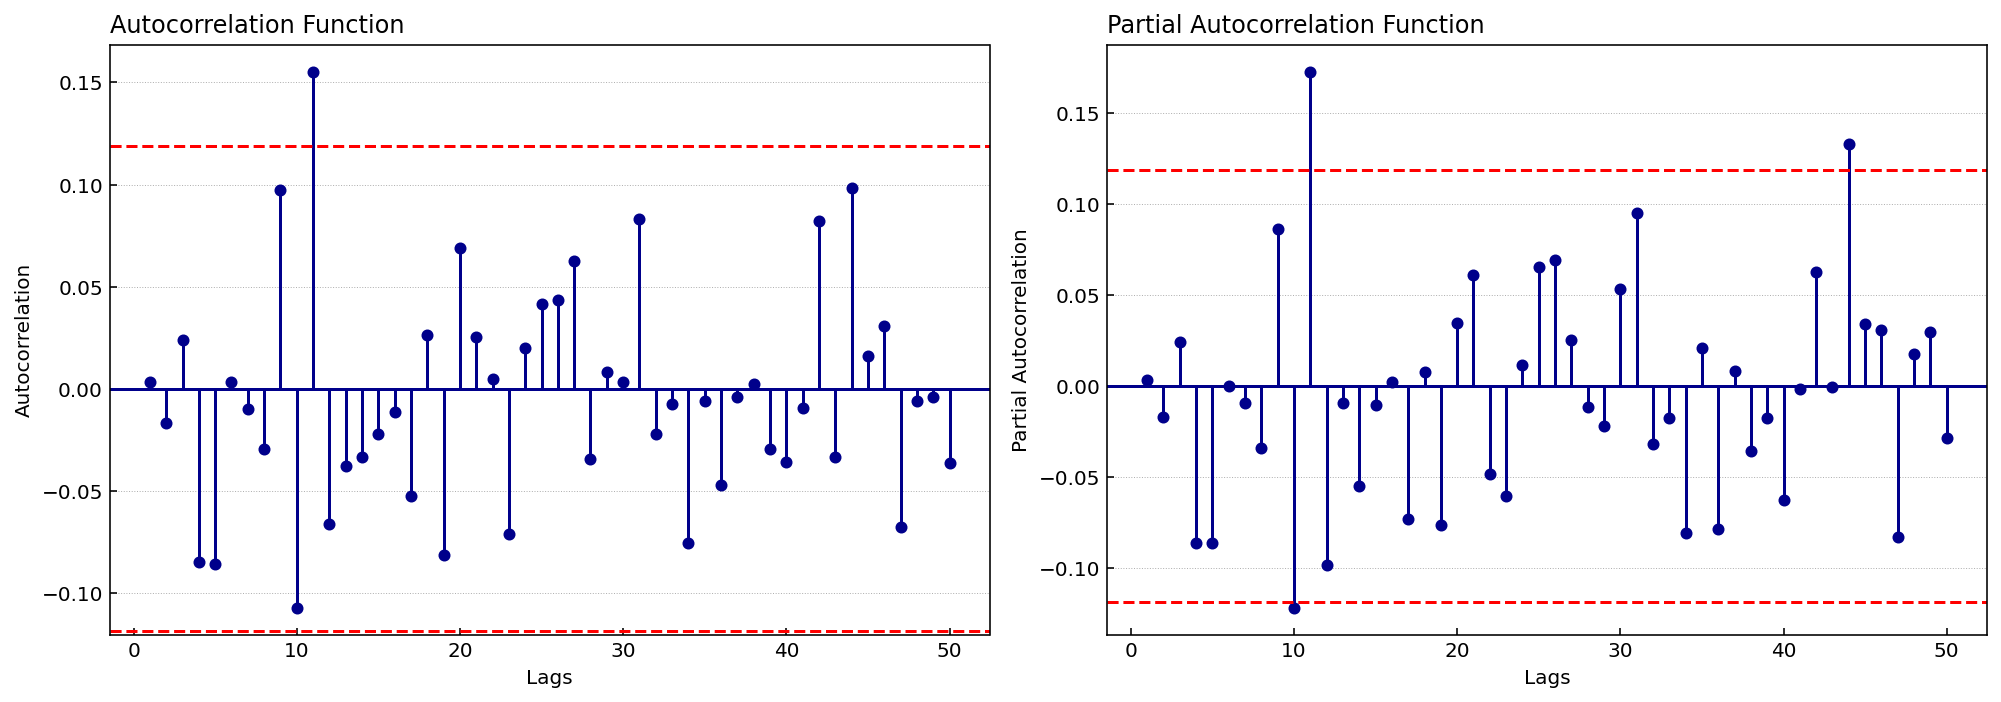

In [23]:
acf_plot(df["IMP"])

### Unemployment Rate

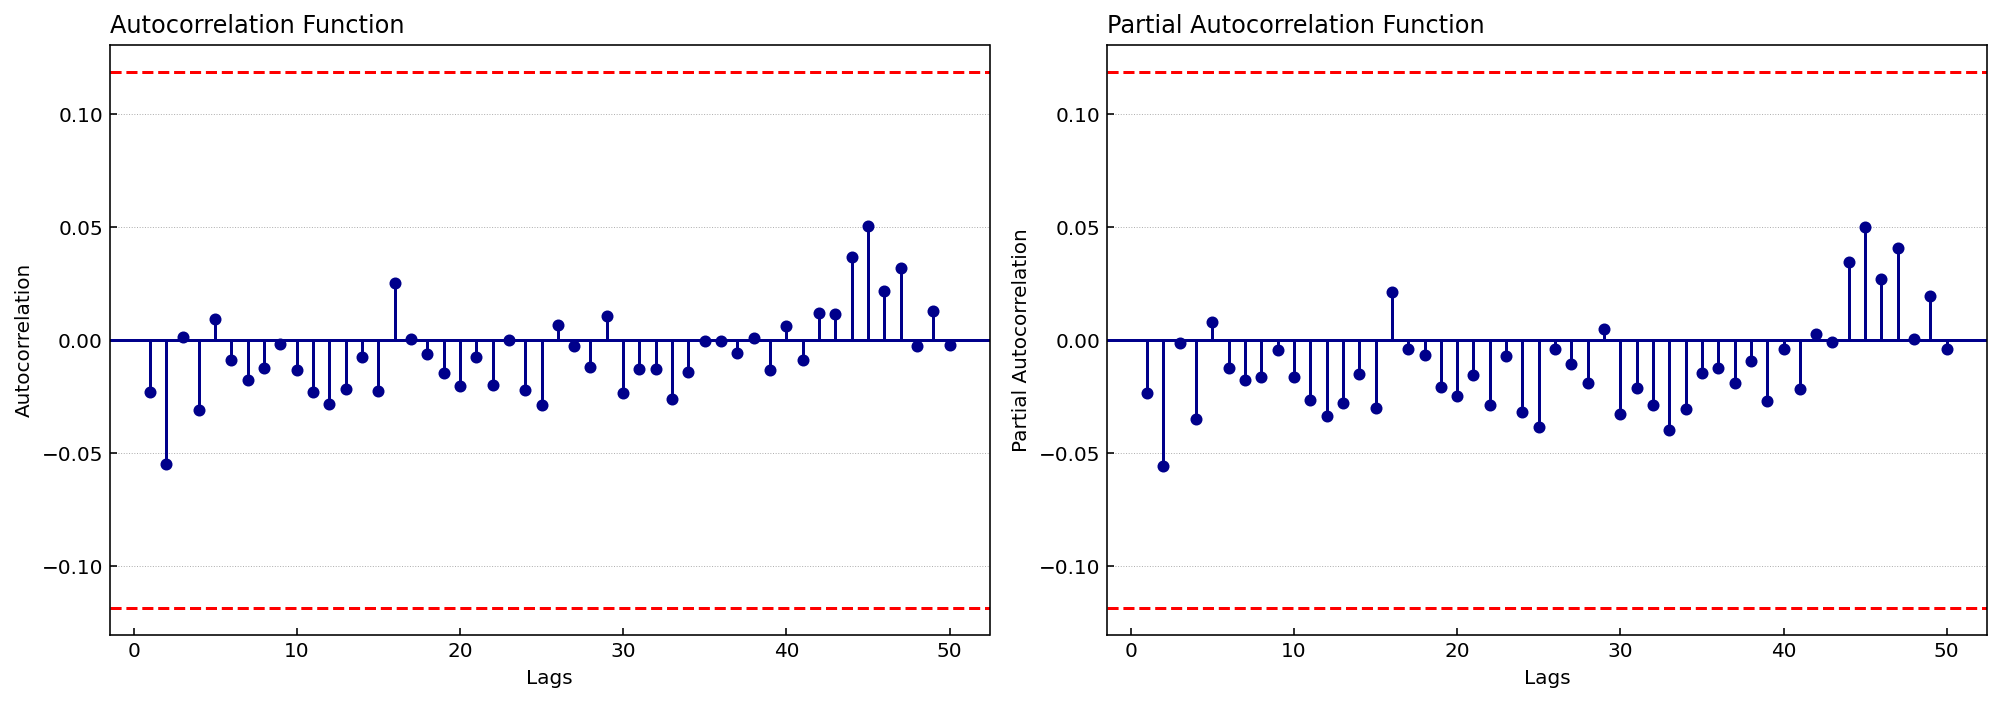

In [24]:
acf_plot(df["UNR"])

In [25]:
# Ljung-Box-Q test
# null hypothesis : data is independently distributed (no autocorrelation)
# alternate hypothesis : data is not independently distributed
# reject null hypothesis if p-value <= 0.05
def lbq_test(data):
    lbq = acorr_ljungbox(data, lags = 100)
    test_statistic, p_value = lbq[0].mean(), lbq[1].mean()
    return test_statistic, p_value

$$ \text{Ljung-Box-Q Test Statistic :} \;\; Q(m) = n(n+2)\sum^{m}_{h=1}\frac{\hat{\varrho}_{h}^2}{n-h} $$

In [26]:
# run the Ljung-Box-Q test
lbq_results = pd.DataFrame(columns = ["t-value", "p-value"], 
                       index = ["EXP", "GDP", "IPI", "IMP", "UNR"])
for column in df:
    lbq_results.loc[column] = lbq_test(df[column])

In [27]:
# print results
lbq_results = lbq_results.astype(float).round(2)
print(lbq_results)

     t-value  p-value
EXP    84.01     0.00
GDP    29.57     0.83
IPI    84.22     0.04
IMP    46.94     0.60
UNR     5.53     0.99


## Granger's Causality

In [28]:
# Granger-Causality test
# null hypothesis : past values of time-series X do not cause the other series Y
# alternate hypothesis : past values of time-series X cause the other series Y
# reject null hypothesis if p-value <= 0.05
def causality_matrix(data, variables):
    # create empty matrix
    matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index = variables)
    for c in matrix.columns:
        for r in matrix.index:
            # fill matrix with p-values for each combination time-series
            test_result = grangercausalitytests(data[[r, c]], maxlag = 50, verbose = False)
            p_values = [test_result[i + 1][0]["ssr_ftest"][1] for i in range(50)]
            min_p_value = np.min(p_values)
            matrix.loc[r, c] = min_p_value
    matrix = matrix.astype(float).round(2)
    return matrix

In [29]:
# print results
print(causality_matrix(df, df.columns))

      EXP   GDP  IPI   IMP   UNR
EXP  1.00  0.00  0.0  0.00  0.03
GDP  0.00  1.00  0.0  0.07  0.00
IPI  0.00  0.04  1.0  0.14  0.00
IMP  0.00  0.00  0.0  1.00  0.00
UNR  0.04  0.00  0.0  0.00  1.00


## Export Data

In [36]:
# select the past two years as test data
# not including the covid-19 pandemic for now
def training_split(data):
    training = data["1950-01-01":"2017-10-01"]
    testing = data["2018-01-01":"2019-10-01"]
    return training, testing

In [37]:
names = ["training", "testing"]

### Univariate Data (ARIMA)

In [38]:
training, testing = training_split(df["GDP"])

In [39]:
# save to current working directory
for i, data in enumerate([training, testing]):
    data.to_csv(os.getcwd() + "/Model Data/Univariate/%s.csv" % (names[i]))

### Multivariate Data (VAR & RandomForest)

In [40]:
training, testing = training_split(df)

In [41]:
# save to current working directory
for i, data in enumerate([training, testing]):
    data.to_csv(os.getcwd() + "/Model Data/Multivariate/%s.csv" % (names[i]))